In [ ]:
# Adding src to the path for modules
import sys
import os
root_path = os.path.abspath('..')
src_path = os.path.join(root_path, 'src')
sys.path.append(src_path)

# Data manipulation
import pandas as pd
import numpy as np

# hypothesis testing
from scipy.stats import stats

# Preliminary training and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Project variables and functions
import config 
import utils
import importlib
importlib.reload(utils)

In [2]:
# Importing data 
df = utils.read_compressed_data(config.COLLECTED_DATA_PATH)

# Defining X and y
features = [col for col in df.columns if 'income' not in col] # all columns that don't have the word income
X = df[features]
y = df['all_work_income']

# Dividing into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=.25)

# Checking split
print(X_train.head())
print(y_train.head())

       state  age  sex  race  literate  highest_educational_level  \
421961    PR   19    1     4         1                          5   
394408    SC   55    1     1         1                          5   
540496    SC   58    2     1         1                          5   
618928    AC   48    2     1         1                          7   
569213    SE   29    1     4         1                          5   

        years_studied  worker_type  work_segment  occupation_group  tax_payer  \
421961             12            7             8                10          1   
394408             12            7             8                 8          1   
540496             12            1             7                 9          1   
618928             15            1             7                 1          1   
569213             12            1             4                 5          1   

        weekly_worked_hours  weekly_worked_hours_all_jobs  
421961                    3           

In [3]:
# Creates pipeline to transform state
pipeline = Pipeline(
    steps=[
        ('state_encoded', OrdinalEncoder())
    ]
)

# Specifies the only column to be transformed
transformer = ColumnTransformer(
    transformers=[
        ('state_transformer', pipeline, ['state'])
    ],
    remainder='passthrough'
)

# Joins pipeline and baseline model
baseline = Pipeline(
    steps=[
        ('transform_state', transformer),
        ('model', RandomForestRegressor(random_state=0))
    ]
)

In [4]:
# Train baseline model
baseline.fit(X_train, y_train)

# Predicts
baseline_predictions = baseline.predict(X_test)

# Scoring
test_r2 = r2_score(y_test, baseline_predictions)
test_mae = mean_absolute_error(y_test, baseline_predictions)
test_mse = mean_squared_error(y_test, baseline_predictions)

# Print scores
print(f'Test R² score {test_r2}')
print(f'Test MAE score {test_mae}')
print(f'Test MSE score {test_mse}')

Test R² score 0.34505023476931007
Test MAE score 1257.1443896414407
Test MSE score 11420964.945808362


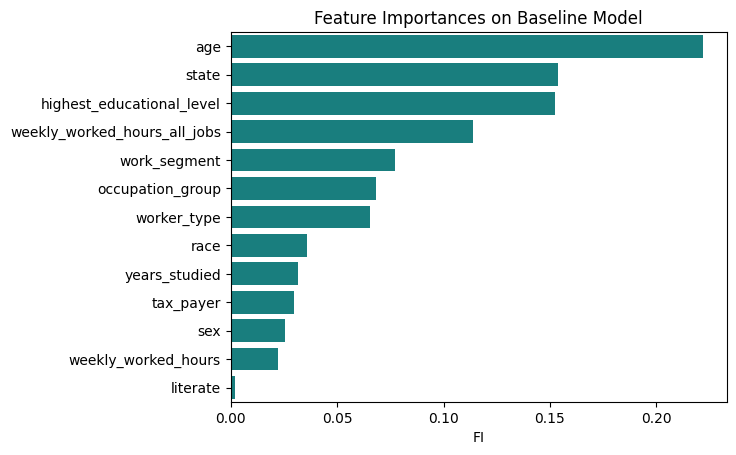

In [5]:
feature_importances = pd.Series(baseline['model'].feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
utils.show_barplot(feature_importances.index, feature_importances, 'Feature Importances on Baseline Model', 'FI')

_____
Testing different number of features:

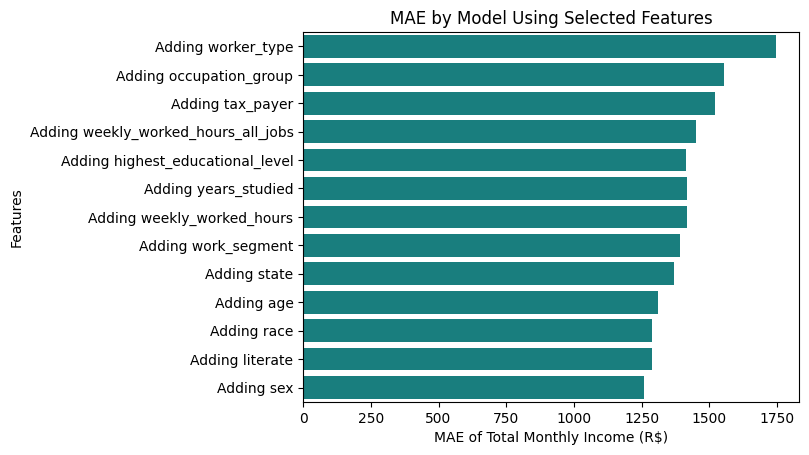

In [16]:
# Uses the list of features ranked by mutual information from eda.ipynb
features_ranked_by_mi = ['worker_type', 'occupation_group', 'tax_payer', 'weekly_worked_hours_all_jobs', 'highest_educational_level', 'years_studied', 
                         'weekly_worked_hours', 'work_segment', 'state', 'age', 'race', 'literate', 'sex']

# Starts empty variable and new instance of model
errors = []
rfr = RandomForestRegressor(random_state=0)

# Iterate through the list, training the model, predicting the income, evaluating and storing in the errors variable
for _ in range(1, len(features_ranked_by_mi)+1):
    if 'state' in X_train[features_ranked_by_mi[:_]].columns:
        baseline.fit(X_train[features_ranked_by_mi[:_]], y_train)
        pred = baseline.predict(X_test[features_ranked_by_mi[:_]])
        errors.append(mean_absolute_error(y_test, pred))
    else:
        rfr.fit(X_train[features_ranked_by_mi[:_]], y_train)
        pred = rfr.predict(X_test[features_ranked_by_mi[:_]])
        errors.append(mean_absolute_error(y_test, pred))

# Plot the scores
utils.show_barplot(
    cat = [f'Adding {feature}' for feature in features_ranked_by_mi],
    values = errors,
    title = 'MAE by Model Using Selected Features',
    x_label = 'MAE of Total Monthly Income (R$)',
    y_label = 'Features'
)